In [1]:
import importlib.util
spec = importlib.util.spec_from_file_location("beam", '/home/rune/Schreibtisch/radioimagepy/radioimagepy/scripts/beam.py')
beam = importlib.util.module_from_spec(spec)
spec.loader.exec_module(beam)

spec = importlib.util.spec_from_file_location("model", '/home/rune/Schreibtisch/radioimagepy/radioimagepy/scripts/model.py')
model = importlib.util.module_from_spec(spec)
spec.loader.exec_module(model)

from astropy.io import fits
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = fits.open('../example_data/beam.fits')
beam_im = data['PRIMARY'].data[0][0]
hdr_beam = data[0].header

cog_x, cog_y, BMIN, BMAJ, BPA = beam.beam_from_image(beam_im)

print(cog_x, cog_y, BMIN, BMAJ, BPA*180/np.pi)

1024 1023 13.921434143982339 41.254337066306476 -3.7478164597696377


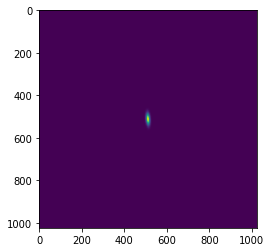

In [3]:
beam_mask = beam.Beam(BMAJ/(2*np.sqrt(2*np.log(2))), BMIN/(2*np.sqrt(2*np.log(2))), np.pi/2+BPA, 1024, 1024)

plt.imshow(beam_mask.get_beam)

In [4]:
flux, r, theta = np.genfromtxt('../example_data/2010-11-01.MOD', unpack=True, skip_header=4)
data = fits.open('../example_data/dirty.fits')
dirty_im = data['PRIMARY'].data[0][0]
hdr_dirty = data[0].header

dx = (np.abs(hdr_beam['CDELT1']) * u.degree).to(u.mas).value
dy = (np.abs(hdr_beam['CDELT2']) * u.degree).to(u.mas).value

xref = hdr_dirty['CRPIX1']
yref = hdr_dirty['CRPIX2']

mod = model.Model(flux, r, theta, dx, dy, xref, yref, 1024, 1024)

/home/rune/.local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


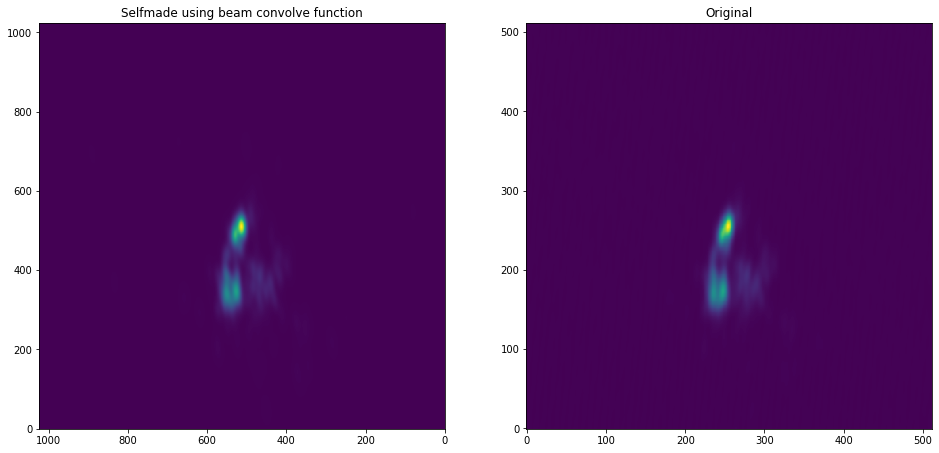

In [12]:
clean_data = fits.open('../example_data/clean.fits')
clean = clean_data['PRIMARY'].data[0][0]

clean_map = beam_mask.convolve(mod.get_model)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))
im = ax1.imshow(clean_map, origin='lower')
ax1.invert_xaxis()
ax1.set_title('Selfmade using beam convolve function')
im2 = ax2.imshow(clean, origin='lower')
ax2.set_title('Original')
fig.show()

/home/rune/.local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


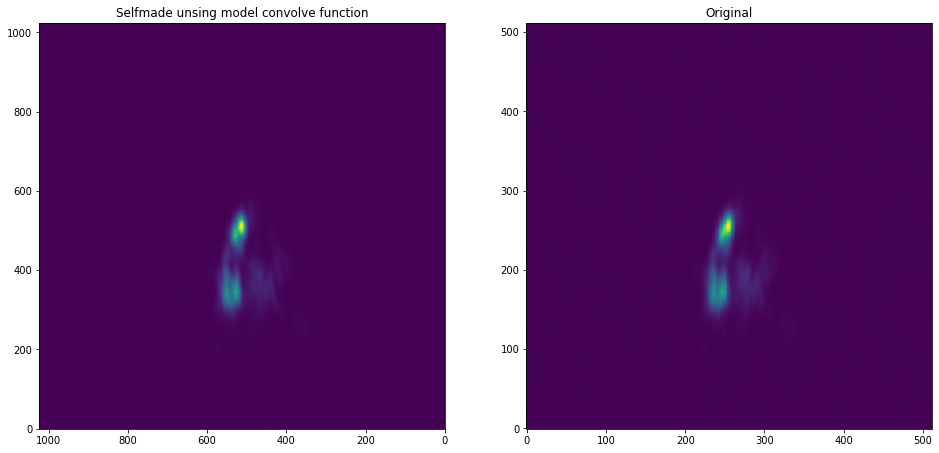

In [13]:
clean_map = mod.convolve(beam_mask.get_beam)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))
im = ax1.imshow(clean_map, origin='lower')
ax1.invert_xaxis()
ax1.set_title('Selfmade unsing model convolve function')
im2 = ax2.imshow(clean, origin='lower')
ax2.set_title('Original')
fig.show()